# FinistR : bootcamp R à Roscoff

## jit with JAX

Make the necessary imports

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '' # uncomment to force CPU

In [2]:
import numpy as np
import math
import pyPLNmodels
import numpy as np
import matplotlib.pyplot as plt
from pyPLNmodels.models import PlnPCAcollection, Pln
from pyPLNmodels.oaks import load_oaks

In [3]:
import jax
import jax.numpy as jnp
import optax
jax.config.update("jax_enable_x64", False)
print(jax.devices())
myfloat = np.float32

[gpu(id=0)]


In [4]:
oaks = load_oaks()
Y = np.asarray(oaks['counts']).astype(myfloat)
Y = np.repeat(Y, 100, axis=0) # make data bigger to feel the speed up
O = np.log(oaks['offsets']).astype(myfloat)
O = np.repeat(O, 100, axis=0) # make data bigger to feel the speed up
X = np.ones([Y.shape[0],1]).astype(myfloat)

N_iter = 5000
lr = 1e-4

### JAX without JIT

### JIT with JAX level 1

Without class method. Without scan function

In [5]:
def init_params(Y, O, X): 
    n, p = Y.shape
    d = X.shape[1]
    ## Variational parameters
    M = jnp.full(Y.shape, 0.0)
    S = jnp.full(Y.shape, 1.0)
    ## Model parameters
    B = jnp.zeros((d, p))
    Sigma = jnp.eye(p)
    Omega = jnp.eye(p)

    return n, p, d, M, S, B, Sigma, Omega

Let's create the jitted functions. Note that `_log_stirling` will be automatically jitted when called the jitted `get_ELBO`. The actual _just in time_ compilation will actually happen at the first execution of the jitted function. Note that the call `jax.jit()` is equivalent to using the decorator `@jax.jit`

In [6]:
def _log_stirling(integer):
    integer_ = integer + (integer == 0)
    return jnp.log(jnp.sqrt(2 * jnp.pi * integer_)) + integer_ * jnp.log(integer_ / jnp.exp(1))
    
def get_ELBO(optim_params, other_params): 
    B, M, S = optim_params['B'], optim_params['M'], optim_params['S']
    X, O, n, Omega, Y, p = (other_params['X'], other_params['O'], 
        other_params['n'], other_params['Omega'], other_params['Y'],
        other_params['p'])
    S2 = jnp.square(S)
    XB = X @ B
    A = jnp.exp(O + M + XB + S2/2)

    elbo = 0.
    elbo = n / 2 * jnp.log(jnp.linalg.det(Omega))
    elbo += jnp.sum(- A + Y * (O + M + XB) + .5 * jnp.log(S2))
    elbo -= .5 * jnp.trace(M.T @ M + jnp.diag(jnp.sum(S2, axis = 0)) @ Omega)
    elbo += .5 * n * p  - jnp.sum(_log_stirling(Y))
    return -elbo

jit_loss_and_grad = jax.jit(jax.value_and_grad(get_ELBO, 0)) # JIT !

def get_Sigma(n, M, S) :
    return 1/n * (M.T @ M + jnp.diag(jnp.sum(S**2, axis = 0)))

jit_getSigma = jax.jit(get_Sigma) # JIT !

jit_inv = jax.jit(jnp.linalg.inv) # JIT !

In the following, each function inside the for loop is jitted but the for loop
is not jitted itself; it is very inefficient to do so in JAX.

In [7]:
def jaxfit1(optim_params, other_params, N_iter, lr, tol = 1e-8) :
    ELBO = jnp.zeros(N_iter)
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init(optim_params)
    objective0 = jnp.inf

    update = jax.jit(optimizer.update)
    apply_updates = jax.jit(optax.apply_updates)

    for i in range(N_iter):
        loss_value, grads = jit_loss_and_grad(
            optim_params,
            other_params
        )

        updates, opt_state = update(grads, opt_state, optim_params)
        optim_params = apply_updates(optim_params, updates)

        ## update parameters with close form
        other_params['Sigma'] = jit_getSigma(other_params['n'], optim_params['M'],
        optim_params['S'])
        other_params['Omega'] = jit_inv(other_params['Sigma'])

        objective = loss_value
        ELBO = ELBO.at[i].set(objective)
    
        #if (abs(objective0 - objective)/abs(objective) < tol):
        #    ELBO = ELBO[0:i]
        #    break
        #else:
        #    objective0 = objective

    return ELBO

Initialize the data for JAX

In [8]:
Y = jnp.asarray(Y)
O = jnp.asarray(O)
X = jnp.array(X)
n, p, d, M, S, B, Sigma, Omega = init_params(Y, O, X)
optim_params = {'B':B, 'M':M, 'S':S}
other_params = {'X':X, 'O':O, 'n':n, 'Omega':Omega, 'Y':Y, 'p':p, 'Sigma':Sigma}

and run the learning process:

In [9]:
%%time
jaxELBO1 = jax.block_until_ready(
    jaxfit1(optim_params, other_params, N_iter, lr=lr, tol=1e-8)
)

CPU times: user 17.2 s, sys: 1.12 s, total: 18.3 s
Wall time: 17.1 s


__NOTE__ Benchmarking JAX:
[https://jax.readthedocs.io/en/latest/async_dispatch.html](https://jax.readthedocs.io/en/latest/async_dispatch.html)

### JIT with JAX level 2

Add the scan function, which is the way to optimize for loops in JAX.
scan() compiles f, so while it can be combined with jit(), it’s usually unnecessary.

In [10]:
def jaxfit2(optim_params, other_params, N_iter, lr, tol = 1e-8) :
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init(optim_params)
    
    def scan_fun(carry, _):
        optim_params = carry['optim_params']
        other_params = carry['other_params']
        loss_value, grads = jax.value_and_grad(get_ELBO)(optim_params,
        other_params)
    
        updates, opt_state = optimizer.update(grads, carry['opt_state'])
        optim_params = optax.apply_updates(optim_params, updates)
    
        ## update parameters with close form
        other_params['Sigma'] = get_Sigma(other_params['n'], optim_params['M'],
        optim_params['S'])
        other_params['Omega'] = jnp.linalg.inv(other_params['Sigma'])
    
        carry['optim_params'] = optim_params
        carry['other_params'] = other_params
        carry['opt_state'] = opt_state
        return carry, loss_value

    
    carry, ELBO = jax.lax.scan(
        scan_fun,
        {
            "optim_params":optim_params,
            "other_params":other_params,
            'opt_state':opt_state
        },
        jnp.arange(N_iter)
    )

    return ELBO

Initialize the data for JAX:

In [11]:
Y = jnp.asarray(Y)
O = jnp.asarray(O)
X = jnp.array(X)
n, p, d, M, S, B, Sigma, Omega = init_params(Y, O, X)
optim_params = {'B':B, 'M':M, 'S':S}
other_params = {'X':X, 'O':O, 'n':n, 'Omega':Omega, 'Y':Y, 'p':p, 'Sigma':Sigma}

__SIDE NOTE__: Perform the Ahead Of Time (AOT) where the compilation is done before hand in a particular explicit step and not at the first execution of the function (JIT). By doing so we can get an estimate of the compilation time.

In [12]:
%%time
lowered = jax.jit(jaxfit2, static_argnums=(2,3,4)).lower(optim_params,
other_params, N_iter, lr=lr, tol=1e-8)
compiled = lowered.compile()

CPU times: user 732 ms, sys: 33 ms, total: 765 ms
Wall time: 513 ms


Let's run the complete fit (including compilation)

In [13]:
%%time
jaxELBO2 = jax.block_until_ready(
    jaxfit2(optim_params, other_params, N_iter, lr, tol=1e-8)
)

CPU times: user 15.3 s, sys: 1.23 ms, total: 15.3 s
Wall time: 15 s


### JIT with JAX level 3

Now we will dive into some of the sharp bits of JAX. Let's try to reuse the above jitted functions with a simple PLN `class` which acts like a container as we did in the _JIT with pytorch_ tutorial.

In [14]:
class PLN_container:
    def __init__(self, Y, O, X): 
        self.Y = Y
        self.O = O
        self.X = X
        self.n, self.p = Y.shape
        self.n = self.n
        self.p = self.p
        self.d = X.shape[1]
        ## Variational parameters
        self.M = jnp.full(Y.shape, 0.0)
        self.S = jnp.full(Y.shape, 1.0)
        ## Model parameters
        self.B = jnp.zeros((self.d, self.p))
        self.Sigma = jnp.eye(self.p)
        self.Omega = jnp.eye(self.p)

Then we would like to adapt the `scan_fun` as:

In [15]:
def jaxfit3(pln, N_iter, lr, tol = 1e-8) :
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init({'B':pln.B, 'M':pln.M, 'S':pln.S})

    def scan_fun(carry, _):
        pln = carry['PLN']
        loss_value, grads = jax.value_and_grad(get_ELBO)(
            {'B':pln.B, 'M':pln.M, 'S':pln.S},
            {'X':pln.X, 'O':pln.O, 'n':pln.n, 'Omega':pln.Omega,
             'Y':pln.Y, 'p':pln.p, 'Sigma':pln.Sigma}
        )
    
        updates, opt_state = optimizer.update(grads, carry['opt_state'])
        updated_params = optax.apply_updates(
            {'B':pln.B, 'M':pln.M, 'S':pln.S},
            updates)
        pln.B = updated_params['B']
        pln.M = updated_params['M']
        pln.S = updated_params['S']
    
        ## update parameters with close form
        pln.Sigma = get_Sigma(pln.N, pln.M, pln.S)
        pln.Omega = jnp.linalg.inv(pln.Sigma)
    
        carry['PLN'] = pln
        carry['opt_state'] = opt_state
        return carry, loss_value
    
    carry, ELBO = jax.lax.scan(
        scan_fun,
        {
            "PLN":pln,
            'opt_state':opt_state
        },
        jnp.arange(N_iter)
    )

    return ELBO

```{python}
pln_container = PLN_container(Y, O, X)
jaxELBO3 = jax.block_until_ready(
    jaxfit3(pln_container, N_iter, lr, tol=1e-8)
)
```

If we run the previous lines, we get an expected error: `class PLN is not a valid JAX type`. Recall that the `scan` loop automatically jits its content and we cannot it function whose arguments are custom classes without specific treatment that we will discover in the next subsection. For the moment, as the class PLN acts as a simple container, a common work around is to use a Python native `namedtuple` class ? 

See this introduction to `namedtuple`: [https://realpython.com/python-namedtuple/](https://realpython.com/python-namedtuple/)

In [16]:
from collections import namedtuple

PLN = namedtuple("PLN", "Y O X n p d M S B Sigma Omega")
pln_namedtuple = PLN(
    Y, O, X,
    Y.shape[0], Y.shape[1], X.shape[1],
    jnp.full(Y.shape, 0.0), jnp.full(Y.shape, 1.0),
    jnp.zeros((X.shape[1], Y.shape[1])), jnp.eye(Y.shape[1]),
    jnp.eye(Y.shape[1]))

Let's adapt the `scan_fun` function

In [17]:
def jaxfit3(pln, N_iter, lr, tol = 1e-8) :
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init({'B':pln.B, 'M':pln.M, 'S':pln.S})

    def scan_fun(carry, _):
        pln = carry['PLN']
        loss_value, grads = jax.value_and_grad(get_ELBO)(
            {'B':pln.B, 'M':pln.M, 'S':pln.S},
            {'X':pln.X, 'O':pln.O, 'n':pln.n, 'Omega':pln.Omega,
             'Y':pln.Y, 'p':pln.p, 'Sigma':pln.Sigma}
        )
    
        updates, opt_state = optimizer.update(grads, carry['opt_state'])
        updated_params = optax.apply_updates(
            {'B':pln.B, 'M':pln.M, 'S':pln.S},
            updates)
        pln = pln._replace(B=updated_params['B'])
        pln = pln._replace(M=updated_params['M'])
        pln = pln._replace(S=updated_params['S'])
    
    
        ## update parameters with close form
        pln = pln._replace(Sigma=get_Sigma(pln.n, pln.M, pln.S))
        pln = pln._replace(Omega=jnp.linalg.inv(pln.Sigma))
    
        carry['PLN'] = pln
        carry['opt_state'] = opt_state
        return carry, loss_value
 
    carry, ELBO = jax.lax.scan(
        scan_fun,
        {
            "PLN":pln,
            'opt_state':opt_state
        },
        jnp.arange(N_iter)
    )

    return ELBO

In [18]:
%%time
jaxELBO3 = jax.block_until_ready(
    jaxfit3(pln_namedtuple, N_iter, lr, tol=1e-8)
)

CPU times: user 15.3 s, sys: 8.45 ms, total: 15.3 s
Wall time: 15 s


Ok, our code works but it is getting a little bit messy: we would like more than containers but real classes, with real methods! That's what we will see in the next section.

### JIT with JAX level 3.5
`dataclasses` as upgraded `namedtuple`

### JIT with JAX level 4
JAX requires the jitted functions to be pure, they cannot have any side effect.

In [19]:
from jax.tree_util import register_pytree_node_class

@register_pytree_node_class
class PLN:
    def __init__(self, Y, O, X): 
        self.Y = Y
        self.O = O
        self.X = X
        self.n, self.p = Y.shape
        self.n = self.n
        self.p = self.p
        self.d = X.shape[1]
        ## Variational parameters
        self.M = jnp.full(Y.shape, 0.0)
        self.S = jnp.full(Y.shape, 1.0)
        ## Model parameters
        self.B = jnp.zeros((self.d, self.p))
        self.Sigma = jnp.eye(self.p)
        self.Omega = jnp.eye(self.p)

    def get_optim_params(self):
        return {'B':self.B, 'M':self.M, 'S':self.S}
        
    def set_optim_params(self, op):
        for k, v in op.items():
            vars(self)[k] = v

    def get_other_params(self):
        return {
            'X':self.X, 'O':self.O, 'n':self.n, 'Omega':self.Omega,
            'Y':self.Y, 'p':self.p, 'Sigma':self.Sigma
        }
        
    def set_other_params(self, op):
        for k, v in op.items():
            vars(self)[k] = v

    def update_Sigma(self):
        pln.Sigma = 1 / self.n * (self.M.T @ self.M + jnp.diag(jnp.sum(self.S ** 2, axis = 0)))

    def update_Omega(self):
        pln.Omega = jnp.linalg.inv(self.Sigma)

    def tree_flatten(self):
        children = (
            self.B, self.M, self.S, self.Sigma, self.Omega,
        )  # arrays / dynamic values
        aux_data = {
            'Y':self.Y, 'O':self.O, 'X':self.X,
            'n':self.n, 'p':self.p, 'd':self.d
        }  # static values
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        (B, M, S, Sigma, Omega) = children
        obj = cls(
            aux_data['Y'], aux_data['O'], aux_data['X']
        )
        obj.B = B
        obj.M = M
        obj.S = S
        return obj

Let's adapt the `scan_fun` function, we are now free to use our new class methods

In [20]:
def jaxfit4(pln, N_iter, lr, tol = 1e-8) :
    optimizer = optax.chain(
        #adam(learning_rate=lr)
        optax.scale_by_radam(),
        optax.scale(-1.0),
        optax.clip(0.1),
    )
    opt_state = optimizer.init(pln.get_optim_params())

    def scan_fun(carry, k):
        pln = carry['PLN']
        loss_value, grads = jax.value_and_grad(get_ELBO)(
            pln.get_optim_params(),
            pln.get_other_params()
        )
    
        updates, opt_state = optimizer.update(grads, carry['opt_state'])
        optim_params = optax.apply_updates(
            pln.get_optim_params(),
            updates
        )
        pln.set_optim_params(optim_params)
    
        ## update parameters with close form
        pln.update_Sigma()
        pln.update_Omega()
    
        carry['PLN'] = pln
        carry['opt_state'] = opt_state
        return carry, loss_value
 
    carry, ELBO = jax.lax.scan(
        scan_fun,
        {
            "PLN":pln,
            'opt_state':opt_state
        },
        jnp.arange(N_iter)
    )

    return ELBO

In [21]:
%%time
pln = PLN(Y, O, X)
jaxELBO4 = jax.block_until_ready(
    jaxfit4(pln, N_iter, lr, tol=1e-8)
)

CPU times: user 18.2 s, sys: 46 ms, total: 18.3 s
Wall time: 15 s


## Conclusion

We check the results

/tmp/ipykernel_14463/2644513083.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(jaxELBO1), label='jit level 1')
/tmp/ipykernel_14463/2644513083.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(jaxELBO2), label='jit level 2')
/tmp/ipykernel_14463/2644513083.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(jaxELBO3), label='jit level 3')


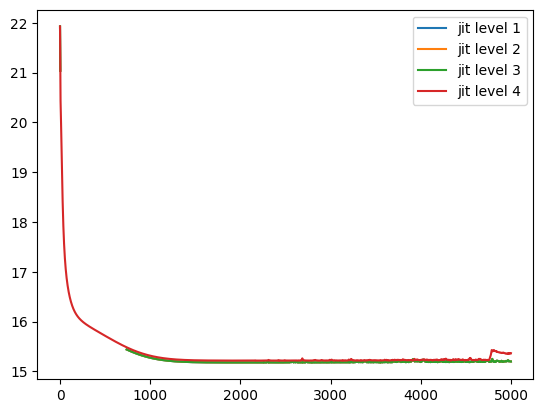

In [22]:
plt.plot(np.log(jaxELBO1), label='jit level 1')
plt.plot(np.log(jaxELBO2), label='jit level 2')
plt.plot(np.log(jaxELBO3), label='jit level 3')
plt.plot(np.log(jaxELBO4), label='jit level 4')
plt.legend()
plt.show()

- Jitting a class is more involved in JAX than with pytorch, the best performances require some specific JAX knowledge that we exposed in each subsection of this document.
- When jitting with JAX we fall back on the same difficulties as when jitting with pytorch trace.
- However, JAX offers clear ways to overcome the difficulties that pytorch tracing does not offer (scan, static_argnums, pytrees, ...)
- In this particular example on **GPU**, **jitted JAX can perform twice as fast as jitted pytorch**. But in this particular example on **CPU**, JAX is slower than pytorch. This is what we can often read online: JAX is particularly suited for GPU optimization. We need to test JAX on other examples involving neural networks, mini-batches, etc. in order to understand JAX potential on CPU optimization too.
